In [1]:
import os
import errno
import numpy as np

import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import callbacks

import deepcell
from deepcell import model_zoo
from deepcell import losses
from deepcell.utils.data_utils import get_data
from deepcell.utils.train_utils import rate_scheduler
from deepcell.utils.tracking_utils import load_trks
from deepcell.utils.tracking_utils import save_trks
from deepcell.utils.retinanet_anchor_utils import get_anchor_parameters
from deepcell.callbacks import RedirectModel, Evaluate
from deepcell.image_generators import RetinaMovieDataGenerator, RetinaNetGenerator
# from deepcell.model_zoo import shapemask_box

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Helper Functions
From `shape_mask` branch

In [2]:
def train_model(model,
                model_dir=None,
                model_name=None,
                train_dict=None,
                test_dict=None,
                batch_size=1,
                num_classes=1,
                fpb=1,
                backbone_levels=None,
                pyramid_levels=None,
                anchor_params=None,
                n_epoch=16,
                optimizer=Adam(lr=1e-5, clipnorm=0.001),
                lr_sched = rate_scheduler(lr=1e-5, decay=0.99)
                ):
    
    if fpb == 1:
        datagen = RetinaNetGenerator(
            rotation_range=180,
            zoom_range=(0.8, 1.2),
            horizontal_flip=True,
            vertical_flip=True)

        datagen_val = RetinaNetGenerator()

        train_data = datagen.flow(
            train_dict,
            batch_size=batch_size,
            include_masks=True,
            include_final_detection_layer=True,
            pyramid_levels=pyramid_levels,
            anchor_params=anchor_params)

        val_data = datagen_val.flow(
            test_dict,
            batch_size=batch_size,
            include_masks=True,
            include_final_detection_layer=True,
            pyramid_levels=pyramid_levels,
            anchor_params=anchor_params)
    
    else:
        datagen = RetinaMovieDataGenerator(
            rotation_range=180,
            zoom_range=(0.8, 1.2),
            horizontal_flip=True,
            vertical_flip=True)

        datagen_val = RetinaMovieDataGenerator()

        train_data = datagen.flow(
            train_dict,
            batch_size=batch_size,
            include_masks=True,
            include_final_detection_layer=True,
            frames_per_batch=fpb,
            pyramid_levels=pyramid_levels,
            anchor_params=anchor_params)

        val_data = datagen_val.flow(
            test_dict,
            batch_size=batch_size,
            include_masks=True,
            include_final_detection_layer=True,
            frames_per_batch=fpb,
            pyramid_levels=pyramid_levels,
            anchor_params=anchor_params)

    retinanet_losses = losses.RetinaNetLosses(
        sigma=3.0,
        alpha=0.25,
        gamma=2.0,
        iou_threshold=0.5,
        mask_size=(28,28))

    loss = {
        'regression': retinanet_losses.regress_loss,
        'classification': retinanet_losses.classification_loss,
        'masks': retinanet_losses.mask_loss,
        'final_detection': retinanet_losses.final_detection_loss
        }

    model.compile(loss=loss, optimizer=optimizer)

    iou_threshold = 0.5
    score_threshold = 0.01
    max_detections = 100

    model.fit_generator(
        train_data,
        steps_per_epoch=X_train.shape[0] * X_train.shape[1]// batch_size,
        epochs=n_epoch,
        validation_data=val_data,
        validation_steps=X_test.shape[0] * X_test.shape[1]// batch_size,
        callbacks=[
            callbacks.LearningRateScheduler(lr_sched),
            callbacks.ModelCheckpoint(
                os.path.join(model_dir, model_name + '.h5'),
                monitor='val_loss',
                verbose=1,
                save_best_only=True,
                save_weights_only=False),
            RedirectModel(
                Evaluate(val_data,
                         iou_threshold=iou_threshold,
                         score_threshold=score_threshold,
                         max_detections=max_detections,
                         frames_per_batch=fpb,
                         weighted_average=True),
                prediction_model)
        ])

    return None

# Train models

In [ ]:
# download_datasets()

DATA_DIR = '/data/training_data/tracking_benchmark_data'

backbones = ['mobilenetv2']
fpbs = [5, 3, 1]
all_data = '3T3_HeLa_HEK_RAW_cropped.npz'
datasets = [all_data]
temporal_modes = ['conv', 'gru', 'lstm', None]
shape_mask = False

n_epoch = 4
seed = 808


for dataset in datasets:
    num_classes=1
    test_size = 0.1 # % of data saved as test
    test_seed = 10

    filename = os.path.join(DATA_DIR, dataset)
    train_dict, test_dict = get_data(filename, seed=seed, test_size=test_size)
    print(' -\nX.shape: {}\ny.shape: {}'.format(train_dict['X'].shape, train_dict['y'].shape))
    X_train, y_train = train_dict['X'], train_dict['y']
    X_test, y_test = test_dict['X'], test_dict['y']
    y_train_reshaped = y_train.reshape((-1,  X_train.shape[2], X_train.shape[3], X_train.shape[4]))
    print("y_train_reshaped shape:", y_train_reshaped.shape)
    optimal_params = get_anchor_parameters(y_train.reshape((-1,  X_train.shape[2], X_train.shape[3], X_train.shape[4])))
    backbone_levels, pyramid_levels, anchor_params = optimal_params
    norm_method='whole_image'
    print("optimal_params: ", optimal_params)

    for backbone in backbones:
        if backbone == 'featurenet':
            use_imagenet=False
        else:
            use_imagenet=True

        for fpb in fpbs:
            if fpb == 1:
                train_dict = {'X':X_train.reshape((-1,X_train.shape[2], X_train.shape[3], X_train.shape[4])), 
                              'y': y_train.reshape((-1,y_train.shape[2], y_train.shape[3], y_train.shape[4]))}
                test_dict = {'X':X_test.reshape((-1, X_test.shape[2], X_test.shape[3], X_test.shape[4])), 
                            'y': y_test.reshape((-1, y_test.shape[2], y_test.shape[3], y_test.shape[4]))}
            else:
                train_dict = {'X':X_train, 'y':y_train}
                test_dict = {'X':X_test, 'y':y_test}
            print(' -\nX.shape: {}\ny.shape: {}'.format(train_dict['X'].shape, train_dict['y'].shape))


            for temporal_mode in temporal_modes:
                model = model_zoo.RetinaMask(backbone=backbone,
                                        use_imagenet=use_imagenet,
                                        panoptic=False,
                                        frames_per_batch=fpb,
                                        temporal_mode=temporal_mode,
                                        num_classes=num_classes,
                                        input_shape=X_train.shape[2:],
                                        anchor_params=anchor_params,
                                        class_specific_filter=False,
                                        backbone_levels=backbone_levels,
                                        pyramid_levels=pyramid_levels,
                                        norm_method=norm_method)
                prediction_model = model

                model_dir = '/data/models'
                model_name = backbone + '_' + 'fpb' + str(fpb) + '_' + str(temporal_mode) + '_' + dataset

                # Train model
                print("Training model: ", model_name)
                trained_model = train_model(model,
                            model_dir=model_dir,
                            model_name=model_name,
                            train_dict=train_dict,
                            test_dict=test_dict,
                            fpb=fpb,
                            backbone_levels=backbone_levels,
                            pyramid_levels=pyramid_levels,
                            anchor_params=anchor_params,
                            n_epoch=n_epoch,
                          )


# Benchmark

In [3]:
# Define data to load (raw images from trk test files)
RAW_BASE_DIR = '/data/training_data/tracking_benchmark_data/test'

raw_trks_3T3  = os.path.join(RAW_BASE_DIR, '3T3_NIH_test_BData.trks')
raw_trks_HEK  = os.path.join(RAW_BASE_DIR, 'HEK293_generic_test_BData.trks')
raw_trks_HeLa = os.path.join(RAW_BASE_DIR, 'HeLa_S3_test_BData.trks')
raw_trks_RAW  = os.path.join(RAW_BASE_DIR, 'RAW264_generic_test_BData.trks')

# raw_trks_files = [raw_trks_3T3, raw_trks_HEK, raw_trks_HeLa]
raw_trks_files = [raw_trks_3T3, raw_trks_HEK, raw_trks_RAW, raw_trks_HeLa]

model_dir = '/data/models'

DATA_DIR = '/data/training_data/tracking_benchmark_data'
dataset = '3T3_HeLa_HEK_RAW_cropped.npz'
filename = os.path.join(DATA_DIR, dataset)
test_size = 0.1 # % of data saved as test
seed = 808
train_dict, test_dict = get_data(filename, seed=seed, test_size=test_size)
X_train, y_train = train_dict['X'], train_dict['y']

In [203]:
import cv2
from skimage import morphology


def draw_masks(image, boxes, scores, masks,
               color=[31, 0, 255],
               score_threshold=0.5,
               binarize_threshold=0.5):
    """Draws a list of masks given a list of boxes.

    Args:
        image (numpy.array): Three dimensional image to draw on.
        boxes (int[]): Matrix of shape (N, >=4)
            (at least 4 values: (x1, y1, x2, y2)) representing boxes
            in the image.
        scores (float[]): A list of N classification scores.
        masks (numpy.array): Matrix of shape (N, H, W) of N masks of shape (H, W)
            which will be reshaped to the size of the corresponding box,
            binarized and drawn over the image.
        color (int[]): Color or to draw the masks with.
        score_threshold (float): Threshold used for determining
            the masks to draw.
        binarize_threshold (float): Threshold used for binarizing the masks.
    """
    selection = np.where(scores > score_threshold)[0]

    for i in selection:
        if not any(b == -1 for b in boxes[i]):
            mask = masks[0]
            box = boxes[i].astype(int)
            mask = mask.astype(np.float32)
            mask = cv2.resize(mask, (box[2] - box[0], box[3] - box[1]))

            # binarize the mask
            mask = (mask > binarize_threshold).astype('uint8')

            # draw the mask in the image
            mask_image = np.zeros((image.shape[0], image.shape[1]), 'uint8')
            mask_image[box[1]:box[3], box[0]:box[2]] = mask
            mask = mask_image

            # apply color to the mask and border
            mask = (np.stack([mask] * 3, axis=2) * color).astype('uint8')

            # draw the mask
            indices = np.where(mask != [0, 0, 0])
            _mask = 0.5 * image[indices[0], indices[1], :] + \
                0.5 * mask[indices[0], indices[1], :]
            image[indices[0], indices[1], :] = _mask
            
    # image = morphology.remove_small_objects(image.astype('uint16'), min_size=100)
    return image

In [204]:
# Make predictions on test data
from deepcell.utils.tracking_utils import load_trks
from deepcell.utils.retinanet_anchor_utils import evaluate

from skimage.morphology import remove_small_objects
import pandas as pd
from deepcell import metrics
from skimage.measure import label
from skimage import morphology
from skimage.morphology import watershed
from skimage.feature import peak_local_max


iou_threshold = 0.5
score_threshold = 0.01
max_detections = 100
num_classes=1

backbones = ['mobilenetv2']
fpbs = [5, 3]

temporal_modes = ['conv', 'gru', 'lstm', None]
shape_mask = False
training_optimal_params = get_anchor_parameters(y_train.reshape((-1,  X_train.shape[2], X_train.shape[3], X_train.shape[4])))

# Go through each Dataset (3T3, HEK293, HeLa, RAW264.7)
for set_num, dataset in enumerate(raw_trks_files):
    print("dataset: ", dataset)
    # Load the trk file       
    trks = load_trks(dataset)
    lineages, raw, tracked = trks['lineages'], trks['X'], trks['y']
    norm_method='whole_image'
    backbone_levels, pyramid_levels, anchor_params = training_optimal_params
    datagen_val = RetinaMovieDataGenerator()
    
    for backbone in backbones:
        if backbone == 'featurenet':
                use_imagenet=False
        else:
            use_imagenet=True
                
        for fpb in fpbs:
            print("frames per batch: ", fpb)
            for temporal_mode in temporal_modes:
                prediction_model = model_zoo.RetinaMask(backbone=backbone,
                                        use_imagenet=use_imagenet,
                                        panoptic=False,
                                        frames_per_batch=fpb,
                                        temporal_mode=temporal_mode,
                                        num_classes=num_classes,
                                        input_shape=trks['X'].shape[2:],
                                        anchor_params=anchor_params,
                                        class_specific_filter=False,
                                        backbone_levels=backbone_levels,
                                        pyramid_levels=pyramid_levels,
                                        norm_method=norm_method)
                # print(prediction_model.summary())

                model_dir = '/data/models/'
                model_name = backbone + '_' + 'fpb' + str(fpb) + '_' + str(temporal_mode) + '_' + '3T3_HeLa_HEK_RAW_cropped.npz'
                print(backbone + '_' + 'fpb' + str(fpb) + '_' + str(temporal_mode))
                prediction_model.load_weights(os.path.join(model_dir, model_name + '.h5'))

                Model_DF = pd.DataFrame(columns=['total_instances', 'mAP'])
                
                Lstats_allmovies = []

                # Go through each batch (movie) in each dataset
                for batch_num, movie in enumerate(trks['X']):
                    Lstats = []
                    print("batch_num: ", batch_num)

                    # Predict on the raw data
                    X_test_temp = np.expand_dims(movie, axis=0)
                    y_test_temp = np.expand_dims(trks['y'][batch_num], axis=0)
                    y_pred = np.zeros(y_test_temp.shape)
                    
                    for index in range(X_test_temp.shape[0]):
                        for frame in range(0, X_test_temp.shape[0]-fpb):
                            image = X_test_temp[index:index + 1, frame:frame + fpb]
                            gt_mask = y_test_temp[index:index + 1, frame:frame + fpb]
                            outputs = prediction_model.predict(image)
                            boxes = outputs[-5]
                            scores = outputs[-4]
                            labels = outputs[-3]
                            masks = outputs[-2]
                            
                            draw_list = []
                            for i in range(fpb):
                                draw = 0.0 * np.tile(image[0, i].copy(), (1, 1, 3))
                                # draw the masks
                                predicted = draw_masks(draw, boxes[0, i], scores[0, i], masks[0, i],
                                           score_threshold=0.5, binarize_threshold=0.5)
                                y_pred[index, frame + i] = predicted
                                
                    for i in range(y_pred.shape[0]):
                        for j in range(y_pred.shape[1]):
                            # Remove small objects from GT for comparison
                            GT_image = y_test_temp[i, j, :, :, :]
                            pred = y_pred[i, j, :, :, :]
                            GT_image = np.expand_dims(GT_image, axis=0)
                            pred = np.expand_dims(pred, axis=0)
                            m = metrics.Metrics(model_name = model_name)
                            m.calc_object_stats(GT_image, pred)
                            Lstats.append(m.stats)
                            
                    Lstats_allmovies.append(Lstats)
                df = pd.concat(Lstats_allmovies)
                print('\n')
                print(backbone + '_' + 'fpb' + str(fpb) + '_' + str(temporal_mode))
                print('\n')
                # Total number of correct detections and incorrect detections
                correct_det = int(df['correct_detections'].sum())
                incorrect_det = int(df['n_pred'].sum() - df['correct_detections'].sum())

                print('Correct Detections: ', correct_det)
                print('Incorrect Detections: ', incorrect_det)

                # Total number of splits, merges, and catastrophes
                splits = df['split'].sum()
                merges = df['merge'].sum()
                catastrophes = df['catastrophe'].sum()

                print('Splits: ', splits)
                print('Merges: ', merges)
                print('Catastrophes: ', catastrophes)

                # Average Recall, Precision, and Jaccard Index
                recall = 100 * df['correct_detections'].sum() / df['n_true'].sum()
                precision = 100 * df['correct_detections'].sum() / df['n_pred'].sum()
                jaccard = df['jaccard'].mean()

                print('Recall: ', recall)
                print('Precision: ', precision)
                print('Average Jaccard Index: ', jaccard)
                            
                        

dataset:  /data/training_data/tracking_benchmark_data/test/3T3_NIH_test_BData.trks
frames per batch:  5
mobilenetv2_fpb5_conv
batch_num:  0

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 9	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 9	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophe

/usr/local/lib/python3.6/dist-packages/deepcell/metrics.py:114: RuntimeWarning: invalid value encountered in long_scalars
  precision = intersection.sum() / pred.sum()
/usr/local/lib/python3.6/dist-packages/deepcell/metrics.py:786: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['correct_detections'].sum() / self.stats['n_pred'].sum(),



____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 10	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 10	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Pred


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 6	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 6	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicte

Missed detections: 7	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 7	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 0

Correct detections:  0	Recall

Gained detections: 0	Perc Error: 0%
Missed detections: 9	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 9	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cell


____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 12	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 13	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Pred

Missed detections: 15	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 15	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 0

Correct detections:  0	Re

Gained detections: 0	Perc Error: 0%
Missed detections: 7	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 7	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cell


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 6	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 6	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicte


____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 8	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 7	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicte


____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 9	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 9	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicte


____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 9	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 8	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicte


____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 10	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 10	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Pred


____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 7	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 7	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicte


____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 12	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 12	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Pred


____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 11	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 11	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Pred


____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 9	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 9	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicte


____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 10	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 11	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Pred


____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 11	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 11	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Pred


____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 12	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 12	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Pred


____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 12	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 12	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Pred


____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 5	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 5	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicte


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 6	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 6	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicte


____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 12	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 12	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Pred


____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 10	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 10	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Pred


____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 8	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 8	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicte


____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 16	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 16	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Pred


____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 7	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 7	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicte


____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 9	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 9	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicte


____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 15	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 15	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Pred


____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 8	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 8	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicte


____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 8	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 8	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicte


____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 10	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 10	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Pred


____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 13	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 


____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 13	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Pred

TypeError: cannot concatenate object of type '<class 'list'>'; only Series and DataFrame objs are valid

# Display data

W0130 18:08:31.812520 139865598736192 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0130 18:08:31.823864 139865598736192 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0130 18:08:31.835214 139865598736192 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0130 18:08:31.846717 139865598736192 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0130 18:08:31.858216 139865598736192 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


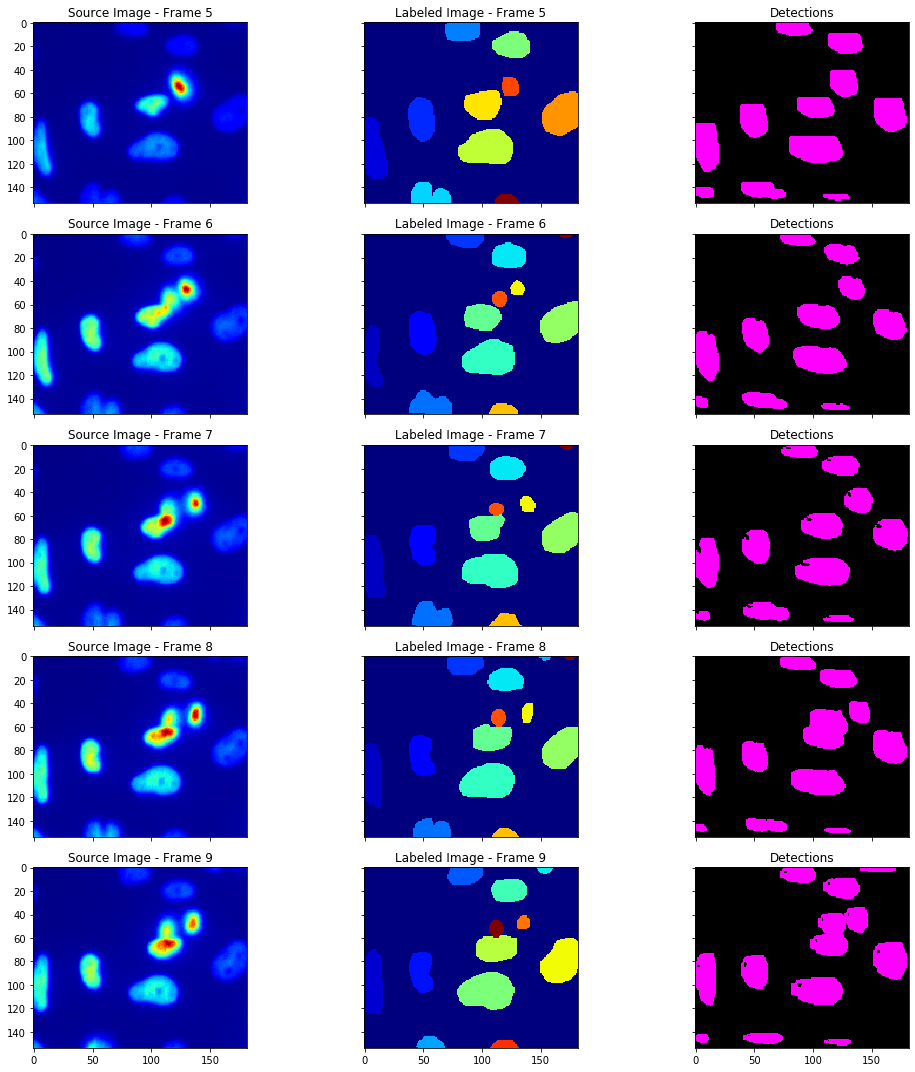

In [202]:
import matplotlib.pyplot as plt

from deepcell.utils.plot_utils import draw_detections

frame = 5
index = 0
image = X_test_temp[index:index + 1, frame:frame + fpb]
gt_mask = y_test_temp[index:index + 1, frame:frame + fpb]

outputs = prediction_model.predict(image)
boxes = outputs[-5]
scores = outputs[-4]
labels = outputs[-3]
masks = outputs[-2]
final_scores = outputs[-1]

display = 0.01 * np.tile(np.expand_dims(image[0, ..., 0], axis=-1), (1, 1, 3))
gt_mask = np.squeeze(gt_mask)

draw_list = []

for i in range(fpb):
    draw = 0.0 * np.tile(image[0, i].copy(), (1, 1, 3))

    # draw the masks
    draw = draw_masks(draw, boxes[0, i], scores[0, i], masks[0, i],
               score_threshold=0.5, binarize_threshold=0.5)

#     # draw detections
#     draw_detections(draw, boxes[0, i], scores[0, i], labels[0, i],
#                     label_to_name=lambda x: 'cell', score_threshold=0.5)

    draw_list.append(draw)

fig, axes = plt.subplots(ncols=3, nrows=fpb, figsize=(15, 15), sharex=True, sharey=True)
for i in range(fpb):
    axes[i, 0].imshow(display[i, ..., 0], cmap='jet')
    axes[i, 0].set_title('Source Image - Frame {}'.format(frame + i))

    axes[i, 1].imshow(gt_mask[i], cmap='jet')
    axes[i, 1].set_title('Labeled Image - Frame {}'.format(frame + i))

    axes[i, 2].imshow(draw_list[i], cmap='jet')
    axes[i, 2].set_title('Detections')

fig.tight_layout()
plt.show()

fig.tight_layout()
plt.show()

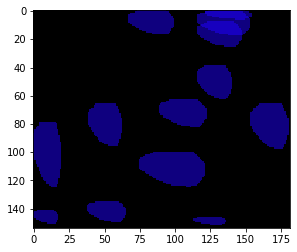

In [191]:
# draw_list[0] = ndi.label(draw_list[0])
plt.imshow(draw_list[2])

In [194]:
X_test_temp.shape

(1, 30, 154, 182, 1)

In [49]:
scores.shape

(1, 5, 100)

In [60]:
labels.shape

(1, 5, 100)

In [62]:
selection.shape

(0,)

In [74]:
gt_mask.shape

(5, 154, 182)

In [75]:
image.shape

(1, 5, 154, 182, 1)